In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import hamming_loss, f1_score, jaccard_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim


In [4]:

def sinusoidal_encoding(coordinates):
    if coordinates.shape[1] != 2:
        raise ValueError("Input array must have two columns (lon, lat)")

    lon = 2 * (coordinates[:, 0] - coordinates[:, 0].min()) / (coordinates[:, 0].max() - coordinates[:, 0].min()) - 1
    lat = 2 * (coordinates[:, 1] - coordinates[:, 1].min()) / (coordinates[:, 1].max() - coordinates[:, 1].min()) - 1


    encoded_lon = np.column_stack([np.sin(np.pi * lon), np.cos(np.pi * lon)])
    encoded_lat = np.column_stack([np.sin(np.pi * lat), np.cos(np.pi * lat)])

    encoded_vector = np.concatenate([encoded_lon, encoded_lat], axis=1)

    return encoded_vector


In [5]:
# loading training data    
data = np.load('data/species_train.npz')
train_locs = data['train_locs']  # 2D array, rows are number of datapoints and 
                                 # columns are "latitude" and "longitude"
train_ids = data['train_ids']    # 1D array, entries are the ID of the species 
                                 # that is present at the corresponding location in train_locs
species = data['taxon_ids']      # list of species IDe. Note these do not necessarily start at 0 (or 1)
species_names = dict(zip(data['taxon_ids'], data['taxon_names']))  # latin names of species 

# loading test data 
data_test = np.load('data/species_test.npz', allow_pickle=True)
test_locs = data_test['test_locs']    # 2D array, rows are number of datapoints 
                                      # and columns are "latitude" and "longitude"
# data_test['test_pos_inds'] is a list of lists, where each list corresponds to 
# the indices in test_locs where a given species is present, it can be assumed 
# that they are not present in the other locations 
test_pos_inds = dict(zip(data_test['taxon_ids'], data_test['test_pos_inds']))    

In [6]:
encoder = OneHotEncoder(sparse_output=False)

# Fittinh and transforming the train_ids to one-hot encoded labels
train_ids_reshaped = train_ids.reshape(-1, 1)
one_hot_encoded_ids = encoder.fit_transform(train_ids_reshaped)
X = sinusoidal_encoding(train_locs)
y = one_hot_encoded_ids
X.shape, y.shape

((272037, 4), (272037, 500))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=41)
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)
print("X_train size : ", X_train.data.size())
print("y_train size : ", y_train.data.size())
print("X_val size : ", X_val.data.size())
print("y_val size : ", y_val.data.size())

X_train size :  torch.Size([217629, 4])
y_train size :  torch.Size([217629, 500])
X_val size :  torch.Size([54408, 4])
y_val size :  torch.Size([54408, 500])


Model with BCE_WAN loss (downweighting the negative class) for Multi Label Classification

In [8]:

def custom_bce_with_logits_loss(inputs, targets, gamma):
    bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    
    # Apply weights only to the negative class
    neg_weight = (1 - targets) * gamma
    weighted_bce_loss = bce_loss * (1 - neg_weight)

    return weighted_bce_loss.mean()

class MultiLabelNeuralNet_BCE(nn.Module):
    def __init__(self, in_features=4, num_classes=500):
        super().__init__()
        self.layer_one = nn.Linear(in_features, 32)
        self.layer_two = nn.Linear(32,64)
        self.layer_three = nn.Linear(64,128)
        self.layer_four = nn.Linear(128,200)
        self.output_layer = nn.Linear(200, num_classes)

        nn.init.xavier_uniform_(self.layer_one.weight)
        nn.init.xavier_uniform_(self.layer_two.weight)
        nn.init.xavier_uniform_(self.layer_three.weight)
        nn.init.xavier_uniform_(self.layer_four.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = nn.functional.relu(self.layer_one(x))
        x = nn.functional.relu(self.layer_two(x))
        x = nn.functional.relu(self.layer_three(x))
        x = nn.functional.relu(self.layer_four(x))
        x = self.output_layer(x)
        return x

model = MultiLabelNeuralNet_BCE()

# Define the custom loss function
L = y_train.shape[1]
gamma = (L-2)/(L-1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.007)

num_epochs = 150
train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model.forward(X_train)
    
    # Calculate the custom loss
    loss = custom_bce_with_logits_loss(outputs, y_train, gamma = gamma)
    
    train_losses.append(loss.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Update the weights
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model.forward(X_val)
        val_loss = custom_bce_with_logits_loss(val_outputs, y_val, gamma=gamma)
        validation_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')



Epoch: 0, Train Loss: 0.00277481647208333, Val Loss: 0.00267602875828743
Epoch: 10, Train Loss: 0.0016488347901031375, Val Loss: 0.0015685989055782557
Epoch: 20, Train Loss: 0.0008900968823581934, Val Loss: 0.0008618018473498523
Epoch: 30, Train Loss: 0.0006873303209431469, Val Loss: 0.0006803360884077847
Epoch: 40, Train Loss: 0.0005878998781554401, Val Loss: 0.0005849273293279111
Epoch: 50, Train Loss: 0.0005359719507396221, Val Loss: 0.0005383692332543433
Epoch: 60, Train Loss: 0.0005050793988630176, Val Loss: 0.0005079933325760067
Epoch: 70, Train Loss: 0.00048730705748312175, Val Loss: 0.0004930646973662078
Epoch: 80, Train Loss: 0.00047127349535003304, Val Loss: 0.0004789553058799356
Epoch: 90, Train Loss: 0.0004589463060256094, Val Loss: 0.0004665541055146605
Epoch: 100, Train Loss: 0.0004540889640338719, Val Loss: 0.0004605827562045306
Epoch: 110, Train Loss: 0.00045692178537137806, Val Loss: 0.000471531820949167
Epoch: 120, Train Loss: 0.0004576223436743021, Val Loss: 0.000458

In [9]:
def create_one_hot_encoded_matrix(test_locs, test_pos_inds):

    unique_species_ids = sorted(test_pos_inds.keys())

    one_hot_encoded_matrix = np.zeros((len(test_locs), len(unique_species_ids)))

    species_id_to_index = {species_id: index for index, species_id in enumerate(unique_species_ids)}

    for species_id, indices in test_pos_inds.items():
        one_hot_encoded_matrix[indices, species_id_to_index[species_id]] = 1

    return one_hot_encoded_matrix

one_hot_test_data = create_one_hot_encoded_matrix(test_locs, test_pos_inds)

In [10]:
X_t = sinusoidal_encoding(test_locs)
y_t = one_hot_test_data
X.shape, y.shape
X_tt = torch.FloatTensor(X_t)
y_tt = torch.FloatTensor(y_t)
print("X_test size : ", X_tt.data.size())
print("y_test size : ", y_tt.data.size())


X_test size :  torch.Size([288122, 4])
y_test size :  torch.Size([288122, 500])


In [11]:
with torch.no_grad():
    y_test = model.forward(X_tt)
    test_loss = custom_bce_with_logits_loss(y_test,y_tt, gamma = gamma)

test_loss

tensor(0.0085)

In [12]:
threshold = 0.5
predictions = (torch.sigmoid(y_test) > threshold).float()

predictions_np = predictions.numpy()
y_true_np = y_tt.numpy()

predictions = predictions.numpy()  
true_labels= y_tt.numpy() 

y_true = true_labels
y_pred = predictions

In [13]:
import warnings
# Hamming Loss
hamming_loss = metrics.hamming_loss(y_true, y_pred)
print(f'Hamming Loss: {hamming_loss:.4f}')
hamming_accuracy = 1 - hamming_loss
print(f'Hamming Accuracy: {hamming_accuracy:.4f}')

# Jaccard Score
jaccard_score_micro= metrics.jaccard_score(y_true, y_pred, average='micro')
print(f'Jaccard Score_micro: {jaccard_score_micro:.4f}')
jaccard_score_macro= metrics.jaccard_score(y_true, y_pred, average='macro')
print(f'Jaccard Score-macro: {jaccard_score_macro:.4f}')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(classification_report(y_true,y_pred, target_names = species.sort()))

Hamming Loss: 0.0348
Hamming Accuracy: 0.9652
Jaccard Score_micro: 0.2078
Jaccard Score-macro: 0.1635
              precision    recall  f1-score   support

           0       0.06      0.99      0.12       619
           1       0.14      0.34      0.20      2234
           2       0.10      0.96      0.17      2926
           3       0.08      0.56      0.14       685
           4       0.10      0.92      0.19       850
           5       0.09      1.00      0.17       631
           6       0.28      0.70      0.40      4960
           7       0.42      0.71      0.53      6939
           8       0.00      0.00      0.00       253
           9       0.22      0.91      0.36      3012
          10       0.17      0.27      0.21       814
          11       0.29      0.95      0.45      4060
          12       0.08      1.00      0.14      1759
          13       0.05      0.95      0.09      1605
          14       0.06      1.00      0.11       277
          15       0.18      0.89

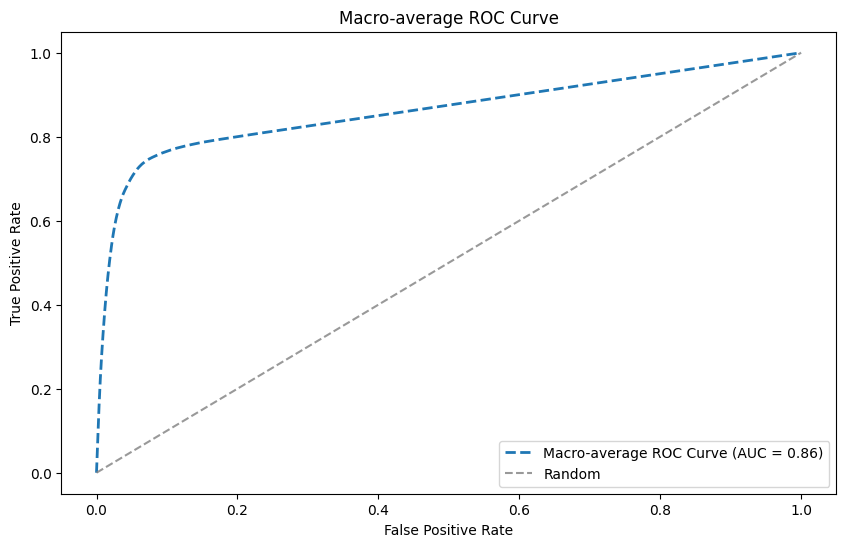

In [14]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(predictions.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(predictions.shape[1])]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(predictions.shape[1]):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= predictions.shape[1]

roc_auc["macro"] = auc(all_fpr, mean_tpr)


plt.figure(figsize=(10, 6))
plt.plot(all_fpr, mean_tpr, label=f'Macro-average ROC Curve (AUC = {roc_auc["macro"]:.2f})', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random', alpha=0.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()
